In [5]:
import os
import requests
from datetime import datetime as dt
import pandas as pd

%matplotlib inline
pd.get_option("display.max_columns")

20

In [6]:
url = 'https://www.tepco.co.jp/forecast/html/images/juyo-d1-j.csv'
file_dir = '/home/wataru/code/crowdworks/FOR_SKYIT/assignment/pred_app/csv'
file_path = os.path.join(file_dir, os.path.basename(url))

In [8]:
dataframe_src = pd.read_csv(os.path.join(file_dir, 'juyo-d1-j.csv'), header=1, encoding='shift-jis')
# dt_last = dt.strptime(list(dataframe_src.tail(1).DATE)[0], '%Y/%m/%d').date()
# dt_now = dt.today().date()

FileNotFoundError: [Errno 2] No such file or directory: '/home/wataru/code/crowdworks/FOR_SKYIT/assignment/pred_app/csv/juyo-d1-.csv'

In [4]:
dataframe = pd.read_csv(file_path, header=1, encoding='shift-jis')
dataframe.head(200)

,ピーク時供給力(万kW),時間帯,供給力情報更新日,供給力情報更新時刻,ピーク時予備率(%),ピーク時使用率(%)
0,5405,14:00〜15:00,7/21,1:20,18,85
1,予想最大電力(万kW),時間帯,予想最大電力情報更新日,予想最大電力情報更新時刻,NaN,NaN
2,4595,14:00〜15:00,7/21,1:20,NaN,NaN
3,使用率ピーク時供給力(万kW),時間帯,供給力情報更新日,供給力情報更新時刻,使用率ピーク時予備率(%),使用率ピーク時使用率(%)
4,3328,1:00〜2:00,7/21,1:20,17,85
...,...,...,...,...,...,...
195,2022/7/21,12:40,NaN,NaN,NaN,NaN
196,2022/7/21,12:45,NaN,NaN,NaN,NaN
197,2022/7/21,12:50,NaN,NaN,NaN,NaN
198,2022/7/21,12:55,NaN,NaN,NaN,NaN


In [5]:
# データの読み込み（データセット中のYのみロード）
dataframe = pd.read_csv(file_path, usecols=[7], header=1, encoding='shift-jis')
dataset = dataframe.values.astype('float32')

### Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

# [0,1]に正規化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### DataSet

In [7]:
# 訓練データとテストデータを分割（時系列の予測が目的のため、ある時点から先をテストデータとする）
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
import numpy as np

# X=[data[t-look_back],...,data[t-1]], Y=data[t]となるデータセットに変換
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]へ変形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM

# LSTMにDenseを接続し、数値を予測（MSEで評価）
model = Sequential()

model.add(LSTM(4, input_shape=(look_back, 1))) # input_shape=(系列長T, x_tの次元), output_shape=(units,)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

2022-07-20 01:08:13.792388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 01:08:13.818321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 01:08:13.818594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 01:08:13.819183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Train

In [26]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation, LSTM

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print(os.getcwd())
MODEL_DIR = os.path.join(os.getcwd(), 'pred_app/model')

batch_size = 2
epochs = 100
chkpt = os.path.join(MODEL_DIR, 'esc50_.{epoch:02d}_{loss:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='loss', verbose=1, save_best_only=True, mode='auto')
es_cb = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[cp_cb, es_cb])

# model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=2)
    # model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

/home/wataru/code/crowdworks/FOR_SKYIT
Epoch 1/100

Epoch 1: loss improved from inf to 0.03037, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/esc50_.01_0.0304.hdf5
64/64 - 0s - loss: 0.0304 - 102ms/epoch - 2ms/step
Epoch 2/100

Epoch 2: loss improved from 0.03037 to 0.03013, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/esc50_.02_0.0301.hdf5
64/64 - 0s - loss: 0.0301 - 99ms/epoch - 2ms/step
Epoch 3/100

Epoch 3: loss did not improve from 0.03013
64/64 - 0s - loss: 0.0302 - 90ms/epoch - 1ms/step
Epoch 4/100

Epoch 4: loss did not improve from 0.03013
64/64 - 0s - loss: 0.0302 - 87ms/epoch - 1ms/step
Epoch 5/100

Epoch 5: loss did not improve from 0.03013
64/64 - 0s - loss: 0.0302 - 86ms/epoch - 1ms/step
Epoch 6/100

Epoch 6: loss did not improve from 0.03013
64/64 - 0s - loss: 0.0303 - 85ms/epoch - 1ms/step
Epoch 7/100

Epoch 7: loss improved from 0.03013 to 0.03004, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/esc

In [16]:
import math
from sklearn.metrics import mean_squared_error

# テストデータに対する予測（評価のため訓練データも）
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 正規化を元に戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 平均二乗誤差のルートで評価
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

2/2 [==============================] - 0s 2ms/step
Train RMSE: 578.56
Test RMSE: 502.36


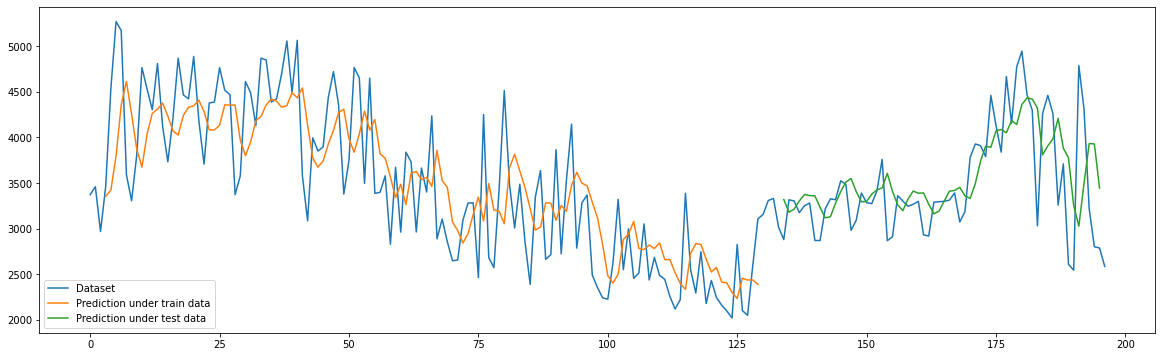

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 訓練データ部分の予測データ
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# テストデータ部分の予測データ
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(20)
plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Prediction under train data')
plt.plot(testPredictPlot, label='Prediction under test data')
plt.legend()
plt.show()